In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [51]:
# read offense data
offense = pd.read_csv('data/offense.csv')
# read defense data
defense = pd.read_csv('data/defense.csv')
# read salary data
salary = pd.read_csv('data/salary.csv', index_col=0)
# change columns (uppercase first letter) to match the other data
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
# read standings data
standings = pd.read_csv('data/standings.csv')

Need to fix the offense and defense stats so that they are the previous year. Can do this by adding 1 to the year before merging the datasets. Salary is known at the beginning of the season so the year doesn't have to change.

In [52]:
offense['Year'] += 1
defense['Year'] += 1

In [53]:
# merge the offense and defense data with suffixes
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
# merge the salary data
combined = pd.merge(combined, salary, on=['Team', 'Year'])
# merge the standings dataframe - use left so 2018 data stays
combined = pd.merge(combined, standings, on=['Team', 'Year'], how='left')

In [54]:
# split out the X and y from combined
X_all = combined[combined.columns[:-8]].copy()
y_all = combined[combined.columns[-8:]].copy()

# add team and year back into y
y_all.insert(0, 'Team', X_all['Team'])
y_all.insert(1, 'Year', X_all['Year'])

In [55]:
target_var = 'Playoffs'

In [41]:
data = X_all.merge(y_all[['Team', 'Year', target_var]])

data_future = data[data['Year'] == 2018]

data = data[data['Year'] < 2018]

features = data.columns[2:-1]

In [42]:
data[target_var].value_counts()

0.0000    100
1.0000     60
Name: Playoffs, dtype: int64

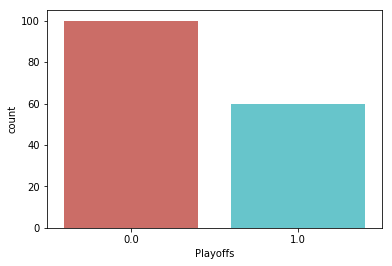

In [43]:
_ = sns.countplot(x='Playoffs', data=data, palette='hls')

In [44]:
data.groupby('Playoffs').mean().T

Playoffs,0.0,1.0
Year,2015.0000,2015.0000
Yds/G_rush_off,109.8120,114.5217
TD_rush_off,12.0400,13.2500
Yds/G_pass_off,234.5430,243.2283
Pct_off,61.5260,63.0617
TD_pass_off,23.8000,26.9333
Sck_off,37.8900,36.5333
Rate_off,85.8630,91.5483
Pts/G_off,21.9560,24.3833
Pen Yds_off,891.6300,888.6667


## Logistic Regression

#### Start with a baseline model

In [45]:
X = data[features]
y = data[target_var]

In [46]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [48]:
X_valid = X[data['Year'] == 2017]
y_valid = y[data['Year'] == 2017]

X = X.loc[data['Year'] < 2017]
y = y.loc[data['Year'] < 2017]

In [49]:
X

,Yds/G_rush_off,TD_rush_off,Yds/G_pass_off,Pct_off,TD_pass_off,Sck_off,Rate_off,Pts/G_off,Pen Yds_off,TO,...,WR,nDL,nLB,nOL,nQB,nRB,nS,nST,nTE,nWR
0,2.7486,2.0086,-0.6872,0.9681,-0.1291,-0.4454,1.3164,1.0254,0.6777,1.7707,...,1.0013,-0.2524,1.8065,-0.5853,0.0710,0.2269,-0.0647,1.3988,-0.1320,0.5255
1,2.5248,0.7408,-1.8948,-0.0005,-0.9235,-0.5470,-0.6342,0.1973,-0.4341,-0.1042,...,-0.6984,0.2861,-0.8069,-0.5853,1.3328,-0.5624,-0.6739,-0.4663,-0.1320,-0.8416
2,2.3629,0.7408,-1.3916,0.4969,0.2681,-0.4454,1.1764,0.6942,-0.0037,1.3541,...,0.5247,1.3630,-0.8069,-0.5853,-1.1908,-0.5624,-0.0647,-0.4663,-0.1320,-0.1581
3,2.1010,0.9521,-0.9115,1.0990,-0.2615,0.3679,1.2324,0.4576,0.4984,0.9374,...,0.5442,-0.2524,-0.2842,-0.5853,-1.1908,0.2269,-0.6739,-0.4663,-0.1320,-0.1581
4,1.8153,-0.7382,-1.9609,-1.2047,-2.2474,0.2662,-2.2581,-2.2872,-1.1299,-2.4998,...,-1.1153,-1.3293,-0.2842,0.7064,0.0710,-0.5624,-1.2830,-0.4663,0.8736,-0.8416
5,1.2867,-0.1043,-0.9632,-0.4193,-0.1291,-0.7503,-0.5408,-0.3233,-0.1400,-1.3541,...,-0.8218,-0.7909,-2.3749,-0.5853,1.3328,-1.3518,-1.2830,1.3988,1.8791,0.5255
6,1.1867,2.6424,1.5411,0.1566,1.1949,-1.0553,0.9057,2.8237,-0.3624,2.6040,...,-0.8428,0.8245,-0.2842,0.0605,-1.1908,-0.5624,-0.6739,-0.4663,-0.1320,0.5255
7,1.0058,1.3747,0.0460,0.4707,-0.3939,-0.9536,0.1125,0.7415,-0.1257,1.2499,...,0.3170,-0.2524,0.2385,0.7064,0.0710,1.8057,-0.0647,-0.4663,0.8736,-0.1581
8,0.9010,1.7973,-0.2185,-1.0738,-0.7911,-0.1404,-0.1395,-0.1340,-0.3982,0.1042,...,-0.4356,0.2861,-1.3295,1.9981,0.0710,-1.3518,-0.6739,-0.4663,-0.1320,1.2090
9,0.5486,-0.3156,-1.4491,-0.7596,-0.5263,0.6728,-0.7088,0.1263,-0.5704,2.0832,...,0.4816,0.2861,-0.8069,0.0605,0.0710,-1.3518,-0.6739,-0.4663,-2.1430,-0.1581
